## Chapter 5 - Support Vector Machines

SVMs are very powerful and versatile ML models, able to perform linear or nonlinear classification, regression and outlier detection.

### Linear SVM Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import make_moons

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Ingest
iris_dataset = datasets.load_iris()
X = pd.DataFrame(iris_dataset['data'], columns=iris_dataset['feature_names'])
y = pd.Series(iris_dataset['target'])
y_names = pd.Series(iris_dataset['target_names'][i] for i in y)

df = X.join(pd.DataFrame(y_names, columns=['y_name']))

In [3]:
# For testing
# display(X.head(2))
# display(y.head(2))
# display(y_names.head(2))
# display(df.head(2))

Consider the Iris dataset. When looking at the scatterplot of the dataset, it is clear that these 2 classes are easily linearly separable.

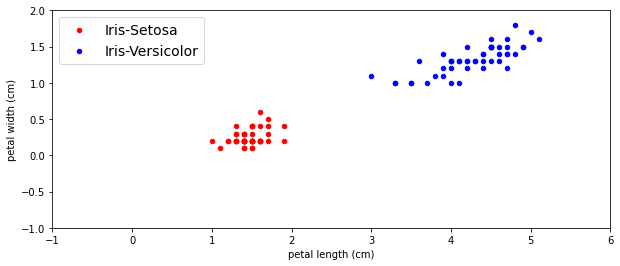

In [4]:
# Scatterplot for only setosa and versicolor
fig, ax = plt.subplots(figsize=(10,4))
df[df.y_name=='setosa'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='red')
df[df.y_name=='versicolor'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='blue')
ax.set_ylim(-1,2)
ax.set_xlim(-1,6)
ax.legend(['Iris-Setosa', 'Iris-Versicolor'], fontsize=14)
plt.show()

An SVM classifier aims to find a line to classify both classes from the dataset. Ideally, the line stays as far away from the closest training instances, or the widest street between the classes. This is called large margin classification.

In [5]:
# Train
df_ex1 = pd.concat([df[df.y_name=='setosa'], df[df.y_name=='versicolor']])
X_ex1 = df_ex1[['petal length (cm)', 'petal width (cm)']]
y_ex1 = df_ex1['y_name']

clf_ex1 = SVC(kernel='linear', C=float('inf'))
clf_ex1.fit(X_ex1, y_ex1)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
# For testing
# print(clf_ex1.coef_[0])
# print(clf_ex1.intercept_)
# print(clf_ex1.support_vectors_)
# print(clf_ex1.support_vectors_.reshape(-2,2))

In [7]:
# Obtain the support vectors and the decision boundary
xmin, xmax = 0,5
x0 = np.linspace(0,5)

w = clf_ex1.coef_[0]
b = clf_ex1.intercept_[0]

# At the decision boundary, w0*x0 + w1*x1 + b = 0
# => x1 = -w0/w1 * x0 - b/w1
x0 = np.linspace(xmin, xmax, 200)
decision_boundary = -w[0]/w[1] * x0 - b/w[1]

margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin
line_df_ex1 = pd.DataFrame({'x' : x0, 'd' : decision_boundary, 'g_up' : gutter_up, 'g_down' : gutter_down})

sv_df_ex1 = pd.DataFrame(clf_ex1.support_vectors_, columns=['x', 'y'])

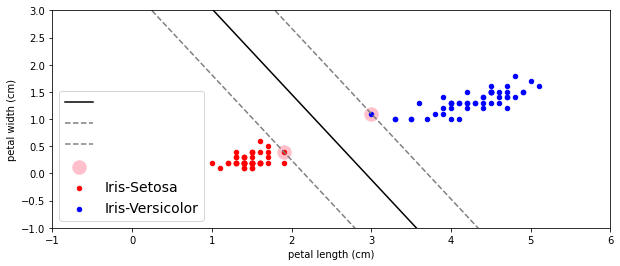

In [8]:
# Plotting the SVM classifier with the dataset
fig, ax = plt.subplots(figsize=(10,4))
line_df_ex1.plot(color='black', kind='line', x='x', y='d', ax=ax)
line_df_ex1.plot(style='--',color='gray', kind='line', x='x', y='g_up',  ax=ax)
line_df_ex1.plot(style='--',color='gray', kind='line', x='x', y='g_down',  ax=ax)
sv_df_ex1.plot(x='x', y='y', kind='scatter', color='pink', s=180, ax=ax)
df[df.y_name=='setosa'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='red')
df[df.y_name=='versicolor'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='blue')
ax.legend(['', '', '', '', 'Iris-Setosa', 'Iris-Versicolor'], fontsize=14)
ax.set_ylim(-1,3)
ax.set_xlim(-1,6)

plt.show()

The instances that lie on the edge of the street are called the support vectors. 
<hr>

Hard margin classification is when strict rules are imposed and all instances be off the street and on the right side. In practice, the data is usually not linearly separater and is can be sensitive to outliers.

### Soft Margin Classification

Soft margin classification is a variation of hard margin classification, particularly allowing some margin violations. In soft margin classification, the objective is to find a good balance between keeping the street as large as possible, and limiting wrongly classified instances.

In sklearn, this can be controlled using the `C` parameter. A high `C` value makes fewer wrong classifications but ends up with a smaller margin, while a low `C` results in a larger street but many instances end up on the street. If the model is overfitting, consider reducing `C`. 

In [9]:
# Ingest
expt1_X = df[['petal length (cm)', 'petal width (cm)']]
expt1_y = y==2
expt1_y = expt1_y.apply(lambda x : 1 if x else 0)
expt1_df = pd.DataFrame({'petal length (cm)' : expt1_X['petal length (cm)'],
                         'petal width (cm)' : expt1_X['petal width (cm)'],
                         'result' : expt1_y})

# Preprocessing
scaler = StandardScaler()
expt1_X_sc = scaler.fit_transform(expt1_X)

expt1_X_sc_df = pd.DataFrame(expt1_X_sc, columns=['length__scaled', 'width__scaled'])
expt1_df = expt1_df.copy().join(expt1_X_sc_df)

In [10]:
# For testing
expt1_df.head(3)

,petal length (cm),petal width (cm),result,length__scaled,width__scaled
0,1.4,0.2,0,-1.340227,-1.315444
1,1.4,0.2,0,-1.340227,-1.315444
2,1.3,0.2,0,-1.397064,-1.315444


In [11]:
# Train for 2 models of differeing C
clf_expt11 = LinearSVC(C=1, loss='hinge')
clf_expt11.fit(expt1_df[['length__scaled', 'width__scaled']], expt1_df['result'])

clf_expt12 = LinearSVC(C=100, loss='hinge')
clf_expt12.fit(expt1_df[['length__scaled', 'width__scaled']], expt1_df['result'])

/Users/bryanlim/.pyenv/versions/3.7.2/envs/interviews/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [12]:
# Predict using both models
X_test = [[5.5,1.7]]
X_test_scl = scaler.transform(X_test)

print(clf_expt11.predict(X_test_scl))
print(clf_expt12.predict(X_test_scl))

[1]
[1]


In [13]:
# Obtain the support vectors and the decision boundary
xmin, xmax = 0,5
x0 = np.linspace(0,5)

w_e1 = clf_expt11.coef_[0]
b_e1 = clf_expt11.intercept_[0]
decision_boundary_e1 = -w_e1[0]/w_e1[1] * x0 - b_e1/w_e1[1]
margin_e1 = 1/w_e1[1]
gutter_up_e1 = decision_boundary_e1 + margin_e1
gutter_down_e1 = decision_boundary_e1 - margin_e1
line_df_expt1 = pd.DataFrame({'x' : x0, 'd' : decision_boundary_e1, 
                            'g_up' : gutter_up_e1, 
                            'g_down' : gutter_down_e1})


w_e2 = clf_expt12.coef_[0]
b_e2 = clf_expt12.intercept_[0]
decision_boundary_e2 = -w_e2[0]/w_e2[1] * x0 - b_e2/w_e2[1]
margin_e2 = 1/w_e2[1]
gutter_up_e2 = decision_boundary_e2 + margin_e2
gutter_down_e2 = decision_boundary_e2 - margin_e2

line_df_expt2 = pd.DataFrame({'x' : x0, 'd' : decision_boundary_e2, 
                            'g_up' : gutter_up_e2, 
                            'g_down' : gutter_down_e2})

In [14]:
import warnings
warnings.filterwarnings("ignore")

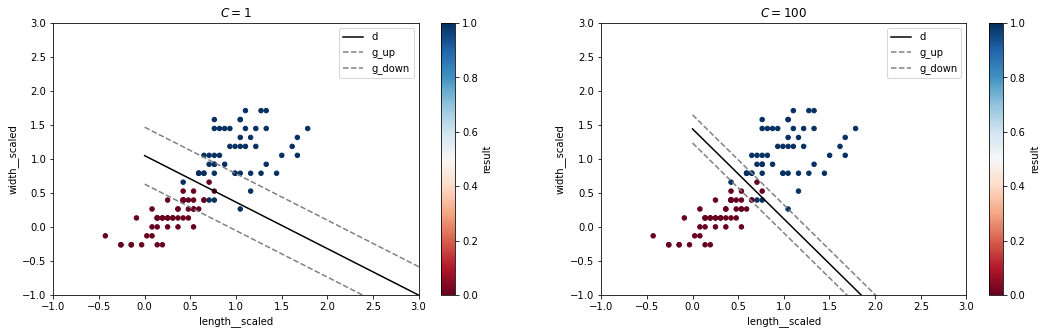

In [15]:
# Visualise the soft margin classifier
fig= plt.figure(figsize=(18,5))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
line_df_expt1.plot(color='black', kind='line', x='x', y='d', ax=ax1)
line_df_expt1.plot(style='--',color='gray', kind='line', x='x', y='g_up',  ax=ax1)
line_df_expt1.plot(style='--',color='gray', kind='line', x='x', y='g_down',  ax=ax1)
expt1_df.plot(kind='scatter', x='length__scaled', y='width__scaled', c='result',
              colormap='RdBu', ax=ax1)
ax1.set_xlim(-1,3)
ax1.set_ylim(-1,3)
ax1.set_title("$C=1$")

line_df_expt2.plot(color='black', kind='line', x='x', y='d', ax=ax2)
line_df_expt2.plot(style='--',color='gray', kind='line', x='x', y='g_up',  ax=ax2)
line_df_expt2.plot(style='--',color='gray', kind='line', x='x', y='g_down',  ax=ax2)
expt1_df.plot(kind='scatter', x='length__scaled', y='width__scaled', c='result',
              colormap='RdBu', ax=ax2)
ax2.set_xlim(-1,3)
ax2.set_ylim(-1,3)
ax2.set_title("$C=100$")

plt.show()

### Nonlinear SVM Classification - Using Polynomial Features

Some datasets are not linearly separable. Sometimes, adding a polynomial feature can result in a linearly separable dataset. To do so, use Polynomial Features in SKLearn.

In [16]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Train on polynomial features
polyfeats = PolynomialFeatures(degree=3)
scl2 = StandardScaler()
clf2 = LinearSVC(C=10, loss='hinge', max_iter=1000000)

X_expt2_feats = polyfeats.fit_transform(X_train)
X_expt2_feats = scl2.fit_transform(X_expt2_feats)
clf2.fit(X_expt2_feats, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [18]:
# Use 3rd degree polynomial and then train SVC on it
clf3= SVC(kernel='poly', degree=3, coef0=1, C=5)
clf3.fit(X_train, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Nonlinear SVM Classification - Using Kernels

In [19]:
# Using the RBF kernel
clf4 = SVC(kernel='rbf', gamma=5, C=0.001)
X_expt3_feats = scl2.fit_transform(X_train)
clf4.fit(X_expt3_feats, y_train)

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

SV Regression (SVR)

In [20]:
# Linear SVR, no polynomial features
svr1 = LinearSVR(epsilon=1.5)
svr1.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [21]:
# Linear SVR, with polynomial features
svr2 = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svr2.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)